In [ ]:
# https://www.youtube.com/watch?v=P6sfmUTpUmc

In [3]:
import torch
import torch.nn.functional as F

import random

import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
words = open("names.txt").read().splitlines()
print(f"{len(words)} examples: {words[:8]}")


32033 examples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [6]:
# build vocabulary of characters and mappings
chars = ["."] + sorted(list(set("".join(words))))
s2i = {s: i for i, s in enumerate(chars)}
i2s = {i: s for i, s in enumerate(chars)}
print(f"Vocab size: {len(i2s)}  \n{i2s}")
vocab_size = len(i2s)

Vocab size: 27  
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [8]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            idx = s2i[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

def get_splits(words, valid_size=0.1, test_size=0.1):
    n_words = len(words)
    random.seed(42)
    random.shuffle(words)

    dev_start = int(n_words * (1 - valid_size - test_size))
    test_start = int(n_words * (1 - test_size))

    X_train, Y_train = build_dataset(words[:dev_start])
    X_dev, Y_dev = build_dataset(words[dev_start:test_start])
    X_test, Y_test = build_dataset(words[test_start:])

    return X_train, Y_train, X_dev, Y_dev, X_test, Y_test

X_train, Y_train, X_dev, Y_dev, X_test, Y_test = get_splits(words)

In [8]:
print(X_test.shape, Y_test.shape)

torch.Size([22866, 3]) torch.Size([22866])


In [82]:
# MLP revisited
vocab_size = len(i2s)
n_embeddings = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embeddings), generator=g)
W1 = torch.randn((n_embeddings * block_size, n_hidden), generator=g) *  5./3. / (n_embeddings * block_size) ** 0.5
b1 = torch.randn((n_hidden,), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 5. / 3. / n_hidden ** 0.5
b2 = torch.randn((vocab_size,), generator=g) * 0

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(f"Number of params: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of params: 12297


In [83]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    batch_idx = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[batch_idx], Y_train[batch_idx]
    batch_embeddings = C[X_batch]
    embcat = batch_embeddings.view(batch_embeddings.shape[0], -1)
    hidden_preact = embcat @ W1 + b1
    
    bnmean_i = hidden_preact.mean(0, keepdim=True)
    bnstd_i = hidden_preact.std(0, keepdim=True)

    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bnmean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bnstd_i

    hidden_preact = bn_gain * (hidden_preact - bnmean_i) / bnstd_i + bn_bias
    hidden_act = torch.tanh(hidden_preact)
    logits = hidden_act @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)

    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = 0.1 if i < max_steps / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"Step {i:7d} / {max_steps:7d}, loss {loss.item():.4f}")
    lossi.append(loss.log10().item())

Step       0 /  200000, loss 3.9446
Step   10000 /  200000, loss 2.1725
Step   20000 /  200000, loss 2.4099
Step   30000 /  200000, loss 2.4611
Step   40000 /  200000, loss 1.9828
Step   50000 /  200000, loss 2.3634
Step   60000 /  200000, loss 2.4155
Step   70000 /  200000, loss 1.9953
Step   80000 /  200000, loss 2.3992
Step   90000 /  200000, loss 2.1629
Step  100000 /  200000, loss 1.9657
Step  110000 /  200000, loss 2.3053
Step  120000 /  200000, loss 2.0005
Step  130000 /  200000, loss 2.4404
Step  140000 /  200000, loss 2.2785
Step  150000 /  200000, loss 2.1575
Step  160000 /  200000, loss 1.9269
Step  170000 /  200000, loss 1.8066
Step  180000 /  200000, loss 2.0369
Step  190000 /  200000, loss 1.9236


In [64]:
batch_mean = hidden_preact.mean(0, keepdim=True)
batch_std = hidden_preact.std(0, keepdim=True)

torch.Size([1, 200])

In [68]:
hidden_preact.shape

torch.Size([32, 200])

In [86]:
@torch.no_grad()
def split_loss(dataset, split):
    x, y = dataset[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hidden_preact = embcat @ W1 + b1
    hidden_preact = bn_gain * (hidden_preact - bn_mean_running) / bn_std_running + bn_bias
    hidden_act = torch.tanh(hidden_preact)
    logits = hidden_act @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

dataset = {"train": (X_train, Y_train), "dev": (X_dev, Y_dev), "test": (X_test, Y_test)}

split_loss(dataset, "train")
split_loss(dataset, "dev")


train 2.0713062286376953
dev 2.1085898876190186


In [87]:
g = torch.Generator().manual_seed(2147483647)

n_examples = 20

for _ in range(n_examples):
    context = [0] * block_size
    name = []
    while True:
        emb = C[torch.tensor(context).unsqueeze(0)]
        embcat = emb.view(emb.shape[0], -1)
        hidden_preact = embcat @ W1 + b1
        hidden_preact = bn_gain * (hidden_preact - bn_mean_running) / bn_std_running + bn_bias
        hidden_act = F.tanh(hidden_preact)
        logits = hidden_act @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        if idx == 0:
            break
        name.append(idx)
        context = context[1:] + [idx]
    print("".join([i2s[i] for i in name]))

junide
jakarie
presay
adria
jimrito
sabe
ger
kalania
zamilena
jadeyaine
amel
sera
evy
arter
nomumahifortum
maryasleigh
ani
cora
yae
anna


In [20]:
logits = torch.tensor([-3.0, 5.0, 0.0, 0.0])
logits = torch.randn((4,)) * 100
probs = torch.softmax(logits, dim=0)
loss = probs.log()
probs, loss

(tensor([9.6436e-01, 3.5637e-02, 2.9427e-44, 2.6591e-16]),
 tensor([-3.6287e-02, -3.3344e+00, -1.0023e+02, -3.5863e+01]))

In [69]:
hidden_preact.shape

torch.Size([32, 200])

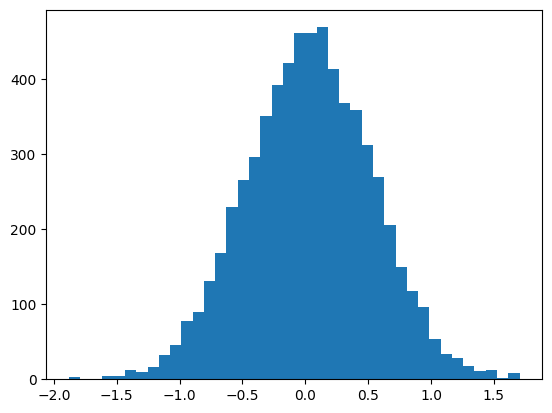

In [52]:
plt.hist(hidden_preact.view(-1).tolist(),40);


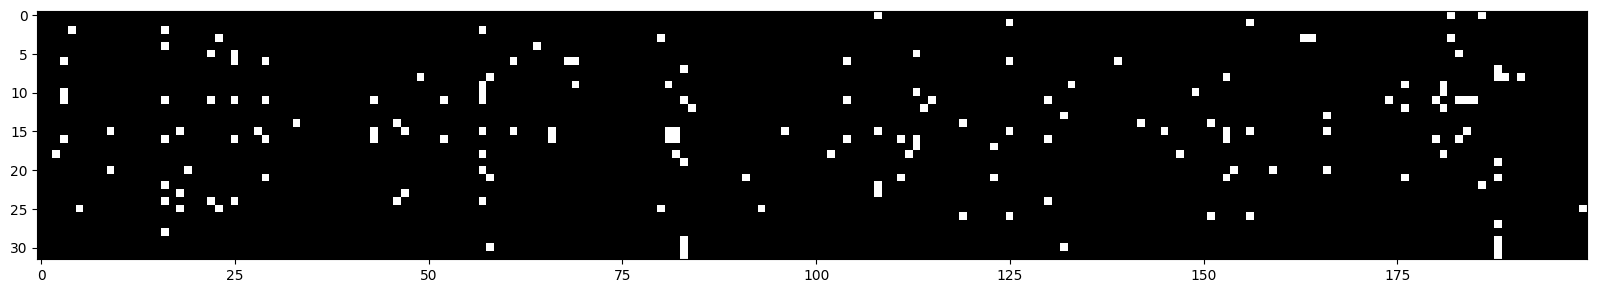

In [53]:
plt.figure(figsize=(20, 10))
plt.imshow(hidden_act.abs() > 0.99, cmap="gray", interpolation="nearest")

tensor([ 8,  4,  4, 20, 12, 20, 26,  6,  7, 16,  5,  3,  6,  8, 10,  9, 16,  5,
         6, 22, 13,  5,  9, 18, 11, 15, 11, 13, 14, 26,  6,  2,  9, 12,  8,  4,
         7,  9,  8, 14, 12,  5,  3, 10,  4,  8, 10,  9, 19, 23, 10,  2, 24, 23,
        22,  6,  8, 20, 19,  3,  3, 14, 14,  8, 21, 14, 16,  6,  6, 13,  2, 22,
        17,  1,  1, 12, 19,  9,  8, 10, 13, 22, 17, 18, 15, 14,  3,  8, 16,  4,
        16, 22,  3, 12,  8,  4,  7,  8,  9,  8,  7, 13,  5,  8, 11,  9,  1,  5,
        10,  6, 19, 24,  6, 27, 13, 22, 11,  4, 19, 12,  1, 14, 13, 26, 15, 15,
         8,  3,  4, 13, 20, 17, 17, 17, 14, 14, 12, 16, 18, 14, 12, 10,  5, 12,
        22, 10, 17,  9,  9,  9,  8, 16, 11, 28, 12,  5, 18,  3,  6, 17, 20,  7,
         3,  3,  4,  3, 13,  9,  8,  6,  5,  8, 19, 10, 12, 18, 20, 10, 10,  2,
        26, 14,  4, 20,  9, 15, 17,  3, 20, 21, 13, 26,  9, 22,  8,  5, 24,  3,
        14, 20])

In [79]:
# calibrate batch norm at the end of training
with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [11]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias: bool = True, generator=None) -> None:
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out)  if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights, self.bias] if self.bias is not None else [self.weights]
    

class BatchNorm1d: 
    def __init__(self, dim, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum

        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)       

    def __call__(self, x):
        if self.training:
            batch_mean = x.mean(0, keepdim=True)
            batch_var = x.var(0, keepdim=True)
            with torch.no_grad():
                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var
        
        x_hat = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def backward(self, dout):
        return dout * (1 - self.out ** 2)
    
    def parameters(self):
        return []

In [35]:
n_embeddings = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embeddings), generator=g)
layers = [
    Linear(n_embeddings * block_size, n_hidden, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, generator=g), , BatchNorm1d(vocab_size),
]
    
with torch.no_grad():
    layers[-1].weights *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(f"Number of params: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

SyntaxError: invalid syntax (630482083.py, line 12)

In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[X_batch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # !!!
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = 0.1 if i < max_steps / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad # type: ignore
    
    if i % 10000 == 0:
        print(f"Step {i:7d} / {max_steps:7d}, loss {loss.item():.4f}")
    lossi.append(loss.log10().item())
    if i > 1000:
        break

Step       0 /  200000, loss 3.2944


Layer 2 mean: -0.0462, std: 0.7580, saturated: 0.2047
Layer 4 mean: -0.0138, std: 0.7229, saturated: 0.1175
Layer 6 mean: 0.0210, std: 0.7401, saturated: 0.1478
Layer 8 mean: -0.0551, std: 0.7324, saturated: 0.1359
Layer 10 mean: -0.0240, std: 0.7131, saturated: 0.1163


Text(0.5, 1.0, 'Histogram of activations')

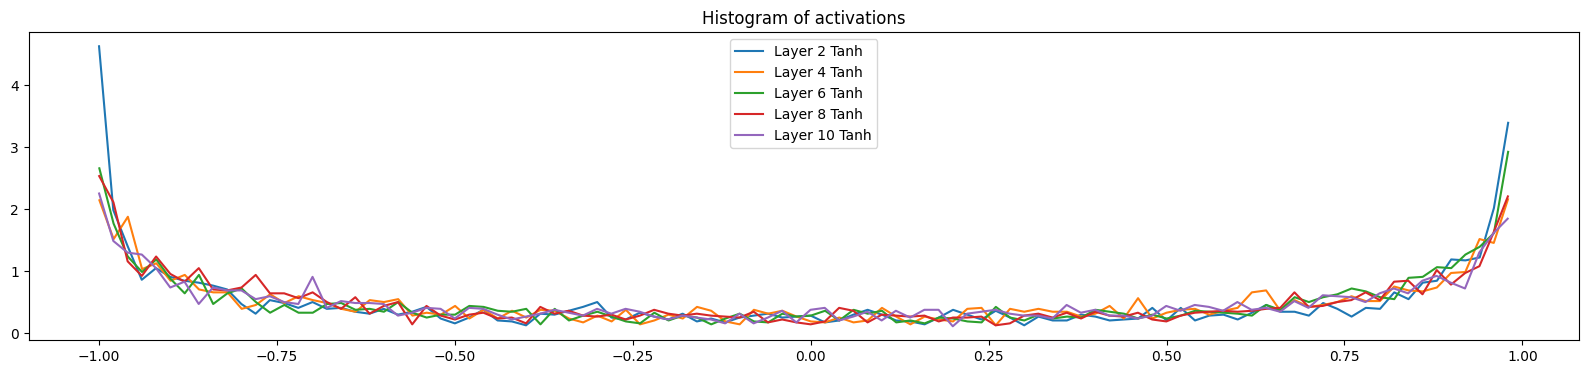

In [36]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i + 1} mean: {t.mean():.4f}, std: {t.std():.4f}, saturated: {(t.abs() > 0.97).float().mean():.4f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i + 1} {layer.__class__.__name__}")
plt.legend(legends)
plt.title("Histogram of activations")	

Layer 2 mean: -0.0000, std: 0.0028, saturated: 0.0000
Layer 4 mean: -0.0000, std: 0.0027, saturated: 0.0000
Layer 6 mean: -0.0000, std: 0.0027, saturated: 0.0000
Layer 8 mean: 0.0000, std: 0.0026, saturated: 0.0000
Layer 10 mean: 0.0000, std: 0.0022, saturated: 0.0000


Text(0.5, 1.0, 'Histogram of activations')

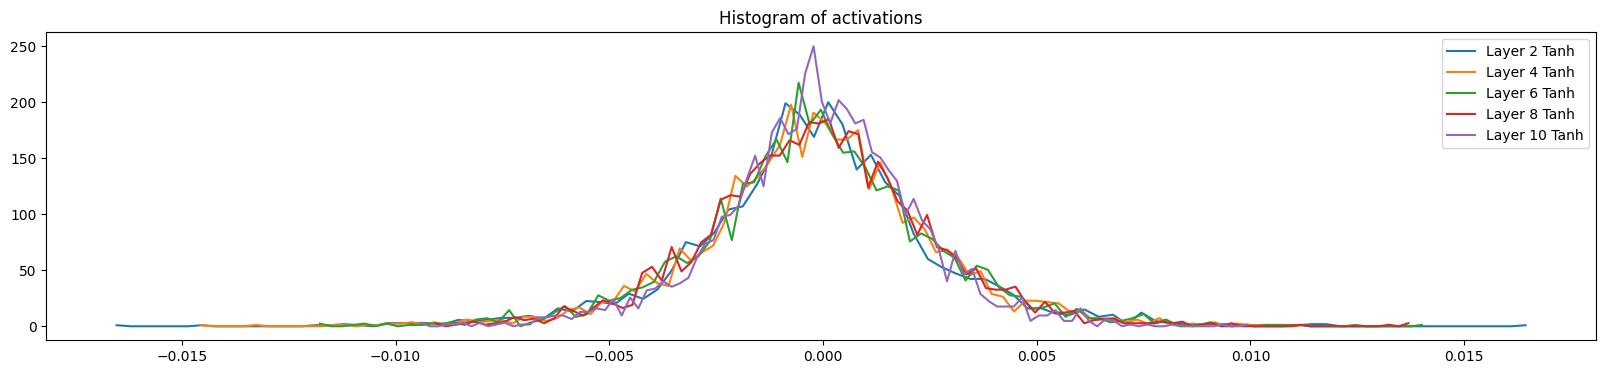

In [37]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {i + 1} mean: {t.mean():.4f}, std: {t.std():.4f}, saturated: {(t.abs() > 0.97).float().mean():.4f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i + 1} {layer.__class__.__name__}")
plt.legend(legends)
plt.title("Histogram of activations")	

weight torch.Size([27, 10]) mean: 0.0005, std: 0.0121, saturated: 0.0000
weight torch.Size([30, 100]) mean: 0.0001, std: 0.0086, saturated: 0.0000
weight torch.Size([100, 100]) mean: -0.0001, std: 0.0067, saturated: 0.0000
weight torch.Size([100, 100]) mean: -0.0000, std: 0.0065, saturated: 0.0000
weight torch.Size([100, 100]) mean: 0.0000, std: 0.0061, saturated: 0.0000
weight torch.Size([100, 100]) mean: -0.0001, std: 0.0052, saturated: 0.0000
weight torch.Size([100, 27]) mean: 0.0000, std: 0.0231, saturated: 0.0000


Text(0.5, 1.0, 'Histogram of activations')

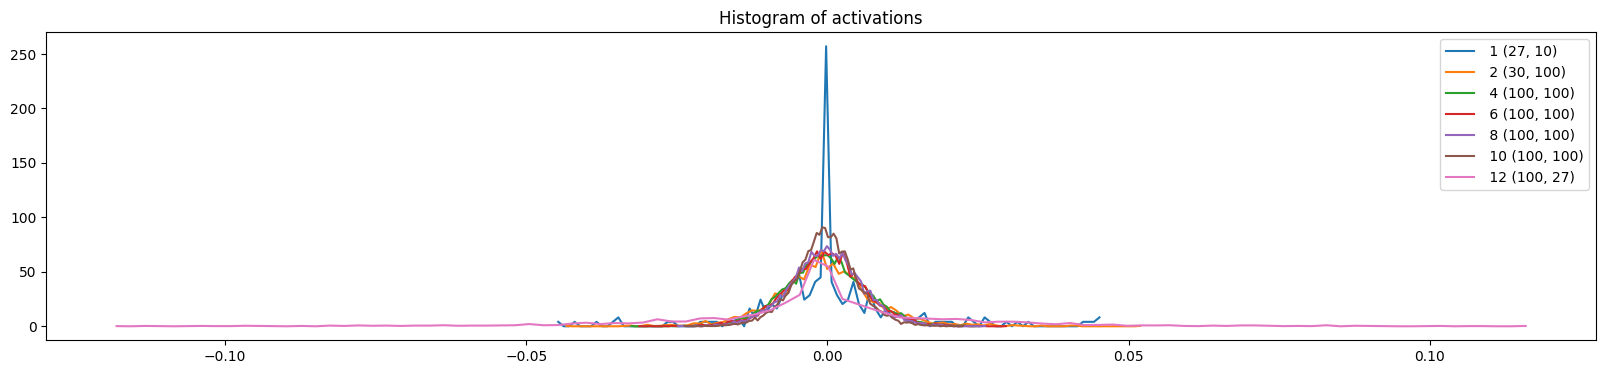

In [38]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight {t.shape} mean: {t.mean():.4f}, std: {t.std():.4f}, saturated: {(t.abs() > 0.97).float().mean():.4f}")
    #print(f"Layer {i + 1} mean: {t.mean():.4f}, std: {t.std():.4f}, saturated: {(t.abs() > 0.97).float().mean():.4f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f" {i + 1} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Histogram of activations")	